# Model quality evaluation

Reproduces Fig. 3, Fig. S2, and Fig. S3 of Zakhartsev et al. "SALARECON connects the Atlantic salmon genome to growth and feed efficiency" (2021).

In [1]:
import cobra
import matplotlib.pyplot as plt
import mptool as mpt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import defaultdict
from matplotlib import rcParams
from os.path import join
from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette

%matplotlib inline
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['mathtext.it'] = 'Arial:italic'
rcParams['mathtext.bf'] = 'Arial:bold'
plot_dir = '../../figures'
data_path = '../../data'
model_path = f'{data_path}/models'
sasa_path = '../../salarecon.xml'

In [2]:
def find_biomass_reactions(model):
    """Returns probable biomass reactions in the model."""

    # Look for biomass in reaction and metabolite IDs
    reactions = set(r for r in model.reactions if 'biomass' in r.id.lower())
    for m in model.metabolites:
        if 'biomass' in m.id.lower():
            reactions |= set(r for r in m._reaction if not r.boundary)
    if reactions:
        return reactions

    # If method above failed, look for largest difference in metabolite counts
    met_count = [len(r.metabolites) for r in model.reactions]
    sorted_met_count = sorted(met_count)
    met_diff = list(np.diff(met_count))
    biomass_met_counts = sorted_met_count[met_diff.index(max(met_diff)) + 1:]
    return set(model.reactions[met_count.index(c)] for c in biomass_met_counts)


def run_task(model, task):
    """Checks if model can perform a metabolic task."""
        
    # Create task reactions
    reactions = create_task_reactions(model, task)
    if not reactions:
        return False

    # Get bounds of boundary reactions before setting them to zero
    bounds = {r: r.bounds for r in model.boundary}
    for r in model.boundary:
        r.bounds = 0, 0
        
    # Add task, solve model, and remove task
    model.add_reactions(reactions)
    sol = model.optimize()
    model.remove_reactions(reactions)
    
    # Reset bounds of boundary reactions
    for r in model.boundary:
        r.bounds = bounds[r]

    return sol.status == 'optimal'


def create_task_reactions(model, task):
    """Creates reactions to represent a metabolic task in a model."""
    
    reactions = []
    
    for x, d in task.items():
        c = 1 if x == 'in' else -1
        for m_id, bounds in d.items():     
            try:
                m = model.metabolites.get_by_id(m_id)
            except KeyError:
                return []
            
            r = cobra.Reaction(m.id + '_' + x)
            r.add_metabolites({m: c})
            r.bounds = bounds
            reactions.append(r)
            
    return reactions

In [3]:
# Load SALARECON
salarecon = cobra.io.read_sbml_model(f'{model_path}/sasa/salarecon.xml')

Academic license - for non-commercial use only - expires 2022-09-29
Using license file c:\gurobi912\gurobi.lic


In [4]:
# Load zebrafish model
zebragem = cobra.io.load_json_model(f'{model_path}/other/ZebraGEM_2_0.json')
#zebragem = cobra.io.read_sbml_model(f'{model_path}/other/ZebraGEM_2_0.xml')

In [5]:
# Load BiGG models
bigg_ids = ('Recon3D', 'iCHOv1', 'iLB1027_lipid', 'iMM1415')
bigg_models = [cobra.io.read_sbml_model(f'{model_path}/bigg/' + x + '.xml') for x in bigg_ids]

No objective coefficients in model. Unclear what should be optimized


In [6]:
# List all models
models = [salarecon, zebragem] + bigg_models
models

[<Model salarecon at 0x14bb7d512b0>,
 <Model ZebraGEM_2_0 at 0x14be6042d68>,
 <Model Recon3D at 0x14be95b68d0>,
 <Model iCHOv1 at 0x14be95b6e80>,
 <Model iLB1027_lipid at 0x14bfdb30a58>,
 <Model iMM1415 at 0x14b877adeb8>]

In [7]:
# Define labels
labels = ['$\it{S. salar}$', '$\it{D.~rerio}$', '$\it{H.~sapiens}$', '$\it{C.~griseus}$', '$\it{P.~tricornutum}$', '$\it{M.~musculus}$']
# labels = [model.id for mode in models]
labels = dict(zip([model.id for model in models], labels))
labels

{'salarecon': '$\\it{S. salar}$',
 'ZebraGEM_2_0': '$\\it{D.~rerio}$',
 'Recon3D': '$\\it{H.~sapiens}$',
 'iCHOv1': '$\\it{C.~griseus}$',
 'iLB1027_lipid': '$\\it{P.~tricornutum}$',
 'iMM1415': '$\\it{M.~musculus}$'}

In [8]:
# Define compartments shared by all models
shared_comp = set(['c', 'm', 'e', 'x', 'cytosol', 'mitochondria', 'extracellular', 'peroxisome'])

In [9]:
# Build binary reaction matrix
d = defaultdict(dict)
for model in models:
    for r in model.reactions:
        if r.boundary:
            continue
        comp = set([x.compartment for x in r.metabolites])
        if len(comp) ==1 and comp <= shared_comp:
            d[labels[model.id]][r.id] = 1
rxn_df = pd.DataFrame(d).fillna(0)
rxn_df.head()

$\it{S. salar}$  $\it{D.~rerio}$  $\it{H.~sapiens}$  \
HMNO                1.0              0.0                0.0   
PGL                 1.0              0.0                1.0   
GND                 1.0              0.0                1.0   
AACOAT              1.0              1.0                1.0   
r0450               1.0              0.0                1.0   

        $\it{C.~griseus}$  $\it{P.~tricornutum}$  $\it{M.~musculus}$  
HMNO                  0.0                    0.0                 0.0  
PGL                   1.0                    1.0                 1.0  
GND                   1.0                    1.0                 1.0  
AACOAT                1.0                    0.0                 1.0  
r0450                 1.0                    0.0                 0.0

In [10]:
# Calculate linkage
metric = 'jaccard'
method = 'complete'
l = linkage(rxn_df.T, metric=metric, method=method)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


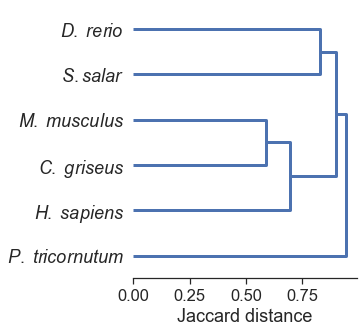

In [11]:
# Plot dendrogram
sns.set(style='ticks', font_scale=1.5)
f = plt.figure()
ax = plt.gca()

palette = ['#e41a1c', '#377eb8']

set_link_color_palette(palette)
with plt.rc_context({'lines.linewidth': 3}):
    r = dendrogram(l, orientation='right', color_threshold=0, labels=rxn_df.columns, ax=ax)

fs = 18
plt.xlabel(metric.capitalize() + ' distance', fontsize=fs)
plt.yticks(fontsize=fs)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

f.set_size_inches(4, 5)
f.savefig(join(plot_dir, 'model_tree.svg'), bbox_inches='tight')

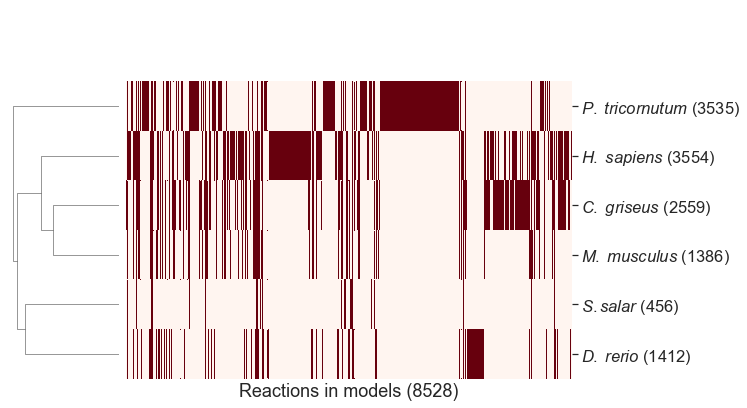

In [12]:
# Plot clustermap
sns.set(font_scale=1.5)
g = sns.clustermap(rxn_df.sort_index().T, row_linkage=l, col_cluster=False, cmap='Reds', cbar=False)
g.ax_heatmap.set_xlabel('Reactions in models ({:.0f})'.format(len(rxn_df)))
g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticklabels([x.get_text() + ' (' + str(int(rxn_df[x.get_text()].sum())) + ')' for x in g.ax_heatmap.get_yticklabels()])
g.ax_cbar.set_visible(False)
g.savefig(join(plot_dir, 'figs2.png'), bbox_inches='tight')

In [13]:
# Load memote subscores
memote_df = pd.read_csv(f'{data_path}/memote_subscores.csv')
memote_df.section = ['Consistency', 'Metabolites', 'Reactions', 'Genes', 'SBO']
memote_df

section     score
0  Consistency  0.983241
1  Metabolites  0.944039
2    Reactions  0.874342
3        Genes  0.709149
4          SBO  1.000000

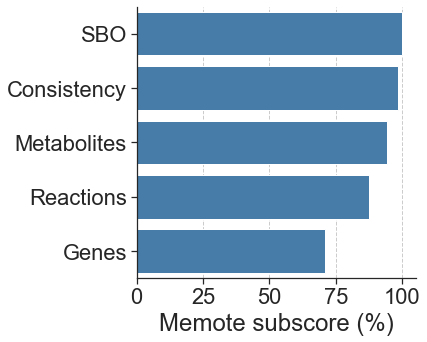

In [14]:
# Plot memote subscores
sns.set(style='ticks', font_scale=2)

f = plt.figure()

df = memote_df.sort_values(by='score', ascending=False)
ax = sns.barplot(y=df.section, x=df.score * 100, color='#377eb8')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.xlabel('Memote subscore (%)')
plt.ylabel('')
plt.xticks([0, 25, 50, 75, 100])
plt.grid(ls='--', axis='x')

sns.despine()
f.set_size_inches(5, 5)
f.savefig(join(plot_dir, 'memote_subscores.svg'), bbox_inches='tight')

In [15]:
# Load metabolic tasks
task_df = pd.read_excel(f'{data_path}/metabolic_tasks.xlsx', engine='openpyxl')

# Rename columns
task_df = task_df.rename(columns={'Unnamed: 12': 'original_tasks'})
task_df = task_df.drop(columns=['Unnamed: 13'])
task_df.columns = [c.replace(' ', '_').lower() for c in task_df.columns]

# Prevent forward filling of pathway cells
task_df.pathways_used = task_df.pathways_used.fillna('')

# Forward fill missing values
columns = ['id', 'system', 'subsystem', 'description', 'should_fail', 'original_source']
task_df[columns] = task_df[columns].fillna(method='ffill')

# Fix metabolite IDs
task_df['in'] = task_df['in'].str.replace('Lcystin', 'cysi_L')
task_df['out'] = task_df['out'].str.replace('Lcystin', 'cysi_L')

# Reformat system and subsystem names
task_df.system = task_df.system.str.capitalize().str.replace('&', 'and')
task_df.subsystem = task_df.subsystem.str.capitalize()
d = {'&': 'and', 'tp ': 'TP ', 'mp ': 'MP ', ' nad ': ' NAD ', ' fad ': ' FAD ', 'b6': 'B6', ' a ': ' A ', 'Gpi ': 'GPI ', ' ros ': ' ROS ', ' / ': '/'}
for k, v in d.items():
    task_df.subsystem = task_df.subsystem.str.replace(k, v)

# Change column types
task_df.id = task_df.id.astype(int)
task_df.should_fail = task_df.should_fail.astype(bool)

# Change compartments that are not in model to cytoplasm
for col in ('in', 'out'):
    for comp in ('r'):
        task_df[col] = task_df[col].str.replace('\[' + comp + '\]', '[c]')

task_df.head()

id             system                  subsystem  \
0   1  Energy metabolism  Oxydative phosphorylation   
1   1  Energy metabolism  Oxydative phosphorylation   
2   1  Energy metabolism  Oxydative phosphorylation   
3   2  Energy metabolism  Oxydative phosphorylation   
4   2  Energy metabolism  Oxydative phosphorylation   

                                         description  should_fail       in  \
0  Oxidative phosphorylation via NADH-coenzyme Q ...        False   q10[m]   
1  Oxidative phosphorylation via NADH-coenzyme Q ...        False  nadh[m]   
2  Oxidative phosphorylation via NADH-coenzyme Q ...        False     h[m]   
3  Oxidative phosphorylation via succinate-coenzy...        False  succ[m]   
4  Oxidative phosphorylation via succinate-coenzy...        False   fad[m]   

   in_lb  in_ub       out  out_lb  ...       reference  \
0    1.0    1.0  q10h2[m]     1.0  ...  PAGE 184 - 186   
1    1.0    1.0    nad[m]     1.0  ...             NaN   
2    5.0    5.0      h[c]     4.0  ...             NaN   
3    1.0    1.0    fum[m]     1.0  ...  PAGE 184 - 186   
4    1.0    1.0  fadh2[m]     1.0  ...             NaN   

                                       pathways_used old_references/comments  \
0  NADH2-u10m (NADH dehydrogenase, mitochondrial ...                     NaN   
1                                                                        NaN   
2                                                                        NaN   
3  SUCD1m (succinate dehydrogenase - fad + succ <...                     NaN   
4                                                                        NaN   

  unnamed:_18 unnamed:_19 unnamed:_20 unnamed:_21  unnamed:_22  unnamed:_23  \
0         NaN         NaN         NaN         NaN          NaN          NaN   
1         NaN         NaN         NaN         NaN          NaN          NaN   
2         NaN         NaN         NaN         NaN          NaN          NaN   
3         NaN         NaN         NaN         NaN          NaN          NaN   
4         NaN         NaN         NaN         NaN          NaN          NaN   

   unnamed:_24  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 24 columns]

In [16]:
# Ensure that amino acid synthesis tasks reflect essentiality in salmon

aa_ess = {
    'Alanine': False,
    'Arginine': True,
    'Asparagine': False,
    'Aspartate': False,
    'Cysteine': False,
    'Glutamine': False,
    'Glutamate': False,
    'Glycine': False,
    'Histidine': True,
    'Isoleucine': True,
    'Leucine': True,
    'Lysine': True,
    'Methionine': True,
    'Phenylalanine': True,
    'Proline': False,
    'Serine': False,
    'Threonine': True,
    'Tryptophan': True,
    'Valine': True
}

for aa, ess in aa_ess.items():
    task_df.loc[task_df.description.str.startswith(aa + ' synthesis'), 'should_fail'] = ess
    
# Cysteine synthesis should fail without serine and methionine
task_df.loc[task_df.id == 82, 'should_fail'] = True

# Synthesis of asparagine from aspartate and glutamine should fail
task_df.loc[task_df.id == 67, 'should_fail'] = True
task_df.loc[task_df.id == 75, 'should_fail'] = True

In [17]:
# Get list of tasks

columns = ['in', 'in_lb', 'in_ub', 'out', 'out_lb', 'out_ub']

tasks = []

for i, df in task_df.groupby('id'):
    df = df[columns]
    df = df.fillna(value={'in_lb': 0, 'out_lb': 0, 'in_ub': 1000, 'out_ub': 1000})
    
    # Get metabolites and their bounds
    task = defaultdict(dict)
    mapped = True
    for x in ('in', 'out'):
        for j, row in df[[c for c in df.columns if c.startswith(x)]].dropna().iterrows():
            m = row[x][:-1].replace('[', '_').replace('_D', '__D').replace('_L', '__L').replace('_R', '__R')
            lb, ub = row[[x + '_lb', x + '_ub']]
            task[x][m] = lb, ub
    
    tasks.append(task)

# Correct coefficient of CO2 in methionine degradation
tasks[115]['out']['co2_c'] = (2.0, 5.0)

tasks

[defaultdict(dict,
             {'in': {'q10_m': (1.0, 1.0),
               'nadh_m': (1.0, 1.0),
               'h_m': (5.0, 5.0)},
              'out': {'q10h2_m': (1.0, 1.0),
               'nad_m': (1.0, 1.0),
               'h_c': (4.0, 4.0)}}),
 defaultdict(dict,
             {'in': {'succ_m': (1.0, 1.0), 'fad_m': (1.0, 1.0)},
              'out': {'fum_m': (1.0, 1.0), 'fadh2_m': (1.0, 1.0)}}),
 defaultdict(dict,
             {'in': {'pyr_m': (1.0, 1.0),
               'nad_m': (1.0, 1.0),
               'coa_m': (1.0, 1.0)},
              'out': {'accoa_m': (1.0, 1.0),
               'nadh_m': (1.0, 1.0),
               'co2_m': (1.0, 1.0)}}),
 defaultdict(dict,
             {'in': {'accoa_m': (1.0, 1.0),
               'gdp_m': (1.0, 1.0),
               'fad_m': (1.0, 1.0),
               'nad_m': (3.0, 3.0),
               'pi_m': (0.0, 1000.0),
               'h2o_m': (2.0, 2.0)},
              'out': {'coa_m': (1.0, 1.0),
               'fadh2_m': (1.0, 1.0),
              

In [18]:
# Drop task columns and resulting duplicate rows from data frame
task_df = task_df.drop(columns=columns).drop_duplicates(subset=['id'], ignore_index=True).dropna(how='all')
task_df.head()

id             system                  subsystem  \
0   1  Energy metabolism  Oxydative phosphorylation   
1   2  Energy metabolism  Oxydative phosphorylation   
2   3  Energy metabolism                Krebs cycle   
3   4  Energy metabolism                Krebs cycle   
4   5  Energy metabolism             ATP generation   

                                         description  should_fail  \
0  Oxidative phosphorylation via NADH-coenzyme Q ...        False   
1  Oxidative phosphorylation via succinate-coenzy...        False   
2  Krebs cycle - oxidative decarboxylation of pyr...        False   
3                      Krebs cycle - NADH generation        False   
4  ATP regeneration from glucose (normoxic condit...        False   

  original_source             original_tasks  \
0            iHSA  inspired from 254 and 252   
1            iHSA          inspired from 252   
2     iHSA/recon2  inspired from 227 and 253   
3            iHSA                        254   
4     iHSA/recon2    inspired from 1 and 302   

                                            comments       reference  \
0  Complex I performs the two electron oxidation ...  PAGE 184 - 186   
1  Complex II is a member of the citrate cycle an...  PAGE 184 - 186   
2  The citrate cycle (also called Krebs cycle or ...      PAGE 55-56   
3  The cycle operates only under aerobic conditio...         PAGE 56   
4  Glycolysis (Embden-Meyerhof pathway) is the co...      PAGE 37-39   

                                       pathways_used old_references/comments  \
0  NADH2-u10m (NADH dehydrogenase, mitochondrial ...                     NaN   
1  SUCD1m (succinate dehydrogenase - fad + succ <...                     NaN   
2  PDHm (pyruvate dehydrogenase - coa + nad + pyr...                     NaN   
3  CSm (citrate synthase - accoa + h2o + oaa --> ...                     NaN   
4                                                                        NaN   

   unnamed:_18  unnamed:_19  unnamed:_20  unnamed:_21  unnamed:_22  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   unnamed:_23  unnamed:_24  
0          NaN          NaN  
1          NaN          NaN  
2          NaN          NaN  
3          NaN          NaN  
4          NaN          NaN

In [19]:
# Run all metabolic tasks and add results to data frame
task_df['feasible'] = [run_task(salarecon, task) for task in tasks]

cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


In [20]:
# Classify successful results
task_df['success'] = ~task_df.feasible.isna() & (task_df.should_fail != task_df.feasible)

In [21]:
# Fraction successful tasks
task_df.success.sum() / len(task_df)

0.6619047619047619

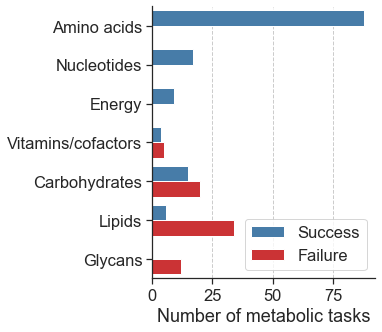

In [22]:
# Plot number of successful tasks by system
sns.set(style='ticks', font_scale=1.5)

f = plt.figure()

df = pd.DataFrame()
df['cnt'] = task_df.groupby('system').success.sum()
df['frac'] = df.cnt / task_df.groupby('system').id.count()
order = df.sort_values(by=['frac', 'cnt'], ascending=False).index

ax = sns.countplot(y=task_df.system, hue=~task_df.success, palette=['#377eb8','#e41a1c'], order=order)
ax.set_yticklabels([x.get_text().capitalize().replace(' and ', 's/').replace(' metabolism', '').replace('an', 'ans').replace('or', 'ors').replace('de', 'des') for x in ax.get_yticklabels()])
ax.legend(['Success','Failure'], title='')
plt.xlabel('Number of metabolic tasks')
plt.ylabel('')
plt.grid(ls='--', axis='x')

sns.despine()
f.set_size_inches(4, 5)
f.savefig(join(plot_dir, 'tasks_system.svg'), bbox_inches='tight')

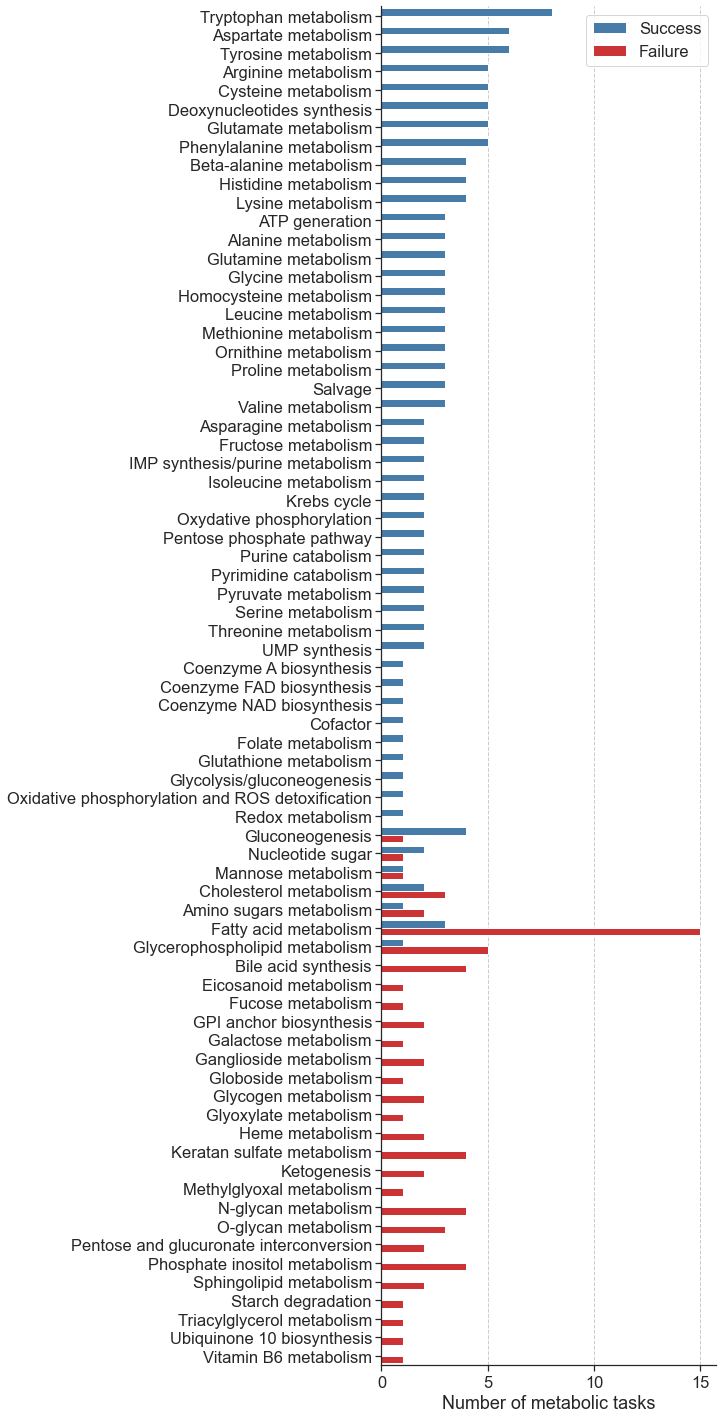

In [23]:
# Plot number of successful tasks by subsystem
sns.set(style='ticks', font_scale=1.5)

f = plt.figure()

df = pd.DataFrame()
df['cnt'] = task_df.groupby('subsystem').success.sum()
df['frac'] = df.cnt / task_df.groupby('subsystem').id.count()
order = df.sort_values(by=['frac', 'cnt'], ascending=False).index

ax = sns.countplot(y=task_df.subsystem, hue=~task_df.success, palette=['#377eb8','#e41a1c'], order=order)
# ax.set_yticklabels([x.get_text().capitalize().replace('&', 'and').replace('tp ', 'TP ').replace('mp ', 'MP ').replace(' nad ', ' NAD ').replace(' fad ', ' FAD ').replace('b6', 'B6').replace(' a ', ' A ').replace('Gpi ', 'GPI ').replace(' ros ', ' ROS ') for x in ax.get_yticklabels()])
ax.legend(['Success','Failure'], title='')
plt.xlabel('Number of metabolic tasks')
plt.ylabel('')
plt.grid(ls='--', axis='x')

sns.despine()
f.set_size_inches(6, 25)
f.savefig(join(plot_dir, 'figs3.png'), bbox_inches='tight')

In [24]:
# Compute AA essentiality
# Essential: Arg, His, Ile, Leu, Lys, Met, Phe, Thr, Trp, and Val

d = defaultdict(list)
aas = ['ala__L', 'arg__L', 'asn__L', 'asp__L', 'cys__L', 'gln__L', 'glu__L', 'gly', 'his__L', 'ile__L', 'leu__L', 'lys__L', 'met__L', 'phe__L', 'pro__L', 'ser__L', 'thr__L', 'trp__L', 'tyr__L', 'val__L']
for aa in aas:
    d['aa'].append(aa)
    r = salarecon.reactions.get_by_id('EX_'+ aa + '_e')
    r.lower_bound = 0
    d['growth'].append(salarecon.optimize().objective_value)
    r.lower_bound = -1000
aa_df = pd.DataFrame(d)
aa_df['essentiality'] = 1 - aa_df.growth / aa_df.growth.max()
aa_df

aa    growth  essentiality
0   ala__L  1.613483  1.443290e-14
1   arg__L  0.000000  1.000000e+00
2   asn__L  1.613483  3.219647e-15
3   asp__L  1.613483  3.219647e-15
4   cys__L  1.613483  3.219647e-15
5   gln__L  1.613483  8.104628e-15
6   glu__L  1.613483  8.104628e-15
7      gly  1.613483  4.218847e-15
8   his__L  0.000000  1.000000e+00
9   ile__L  0.000000  1.000000e+00
10  leu__L  0.000000  1.000000e+00
11  lys__L  0.000000  1.000000e+00
12  met__L  0.000000  1.000000e+00
13  phe__L  0.000000  1.000000e+00
14  pro__L  1.613483  4.440892e-16
15  ser__L  1.613483  2.031708e-14
16  thr__L  0.000000  1.000000e+00
17  trp__L  0.000000  1.000000e+00
18  tyr__L  1.613483  0.000000e+00
19  val__L  0.000000  1.000000e+00

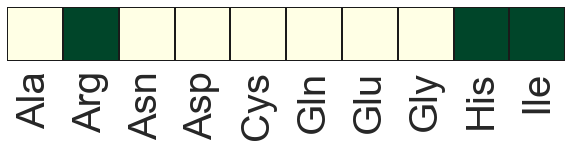

In [25]:
sns.set(font_scale=1)
df = aa_df[:10].copy()
df.index = df.aa

tol = 1e-6

aas = ['ala__L', 'arg__L', 'asn__L', 'asp__L', 'cys__L', 'gln__L', 'glu__L', 'gly', 'his__L', 'ile__L', 'leu__L', 'lys__L', 'met__L', 'phe__L', 'pro__L', 'ser__L', 'thr__L', 'trp__L', 'tyr__L', 'val__L']
# names = ['Ala', 'Arg', 'Asp', 'Cys', 'Gln', 'Glu', 'Gly', 'His', 'Ile', 'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'Ser', 'Thr'

f = plt.figure()
ax = sns.heatmap(df[['growth']].T < tol, cmap='YlGn', cbar=False, lw=1, linecolor='k')
# ax = sns.heatmap(df[['essentiality']].T, cmap='YlOrRd', cbar=False, lw=1, linecolor='k')

plt.xlabel('')
ax.set_yticklabels('')
# ax.set_xticks(range(len(df)))
ax.set_xticklabels([x.get_text()[:3].capitalize() for x in ax.get_xticklabels()], fontsize=40)
f.set_size_inches(10, 1)
f.savefig(join(plot_dir, 'aa_growth_1.svg'), bbox_inches='tight')

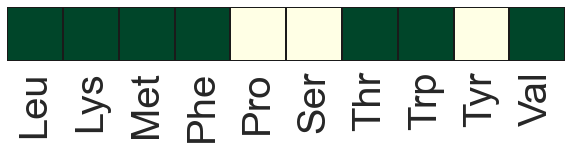

In [26]:
sns.set(font_scale=1)
df = aa_df[10:].copy()
df.index = df.aa

tol = 1e-6

aas = ['ala__L', 'arg__L', 'asn__L', 'asp__L', 'cys__L', 'gln__L', 'glu__L', 'gly', 'his__L', 'ile__L', 'leu__L', 'lys__L', 'met__L', 'phe__L', 'pro__L', 'ser__L', 'thr__L', 'trp__L', 'tyr__L', 'val__L']
# names = ['Ala', 'Arg', 'Asp', 'Cys', 'Gln', 'Glu', 'Gly', 'His', 'Ile', 'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'Ser', 'Thr'

f = plt.figure()
ax = sns.heatmap(df[['growth']].T < tol, cmap='YlGn', cbar=False, lw=1, linecolor='k')
# ax = sns.heatmap(df[['essentiality']].T, cmap='YlOrRd', cbar=False, lw=1, linecolor='k')

plt.xlabel('')
ax.set_yticklabels('')
# ax.set_xticks(range(len(df)))
ax.set_xticklabels([x.get_text()[:3].capitalize() for x in ax.get_xticklabels()], fontsize=40)
f.set_size_inches(10, 1)
f.savefig(join(plot_dir, 'aa_growth_2.svg'), bbox_inches='tight')

In [27]:
# Get RECON3D
recon3d = [x for x in bigg_models if x.id.lower() == 'recon3d'].pop()
recon3d

<Model Recon3D at 0x14be95b68d0>

In [28]:
# Find minimal growth-supporting uptake sets that include essential AAs and oxygen

# Choose model
model = recon3d
model = salarecon

# Choose biomass ID and allow uptake of essential AAs and oxygen
uptakes = set(['o2', 'his__L', 'ile__L', 'leu__L', 'lys__L', 'met__L', 'phe__L', 'thr__L', 'trp__L', 'val__L'])
if model.id.lower() == 'recon3d':
    bm = 'BIOMASS_maintenance'
elif model.id.lower() == 'salarecon':
    bm = 'Biomass'
    uptakes |= set(['arg__L'])

with model as m:
    # Set boundary conditions
    for r in m.boundary:
        m_id = r.reactants[0].id[:-2]
        if m_id in uptakes:
            r.bounds = -1000, -1e-3
        else:
            r.bounds = -1000, 1000

    for r in m.sinks:
        r.lower_bound = 0
    for r in m.demands:
        r.lower_bound = 0

    m.reactions.EX_hco3_e.bounds = 0, 0
    if model.id.lower() == 'recon3d':
        m.reactions.EX_Rtotal_e.bounds = 0, 0
        m.reactions.EX_Rtotal2_e.bounds = 0, 0
        m.reactions.EX_Rtotal3_e.bounds = 0, 0        
        
    # Check feasibility
    sol = m.optimize()
    
    if sol.objective_value > 1e-6:
        # Set minimal growth rate
        m.reactions.get_by_id(bm).lower_bound = 1
        
        # Create Gurobi LP and make boundary reactions irreversible
        lp = mpt.create_lp(m)
        subset = mpt.make_irreversible(lp, [r.id for r in m.boundary])
        
        # Choose uptakes of all metabolites except essential AAs and oxygen as subset for MP enumeration
        subset = set(v.varName for v in subset if v.varName.endswith('_rev') and v.varName[3:-6] not in uptakes)

        # Enumerate MPs with iterative method and graph
        mps, mcs, complete = mpt.find_mps(
            lp,
            subset=subset,
            method='iterative',
            graph=True,
            random=False,
            bounds={v.varName: (v.lb, v.ub) for v in lp.getVars()},
            tol=1e-09,
            inf=1000,
            threads=0,
            max_mps=0,
            max_t=0,
            verbose=True,
            export=True,
        )

C:\NMBU\Miniconda3\envs\salarecon\lib\site-packages\ipykernel_launcher.py:43 DeprecationWarning: Deprecated, pass a TempConstr or use Model.addLConstr


salarecon
Network size: 778
Subset size: 60

Making subset irreversible...

Network size: 778
Subset size: 60

Enumerating MPs...

*
MP 1 ['EX_chol_e_rev', 'EX_pi_e_rev']
New edges: 1
New cliques: 0

*
MC 1 ['EX_pi_e_rev']
MC 2 ['EX_chol_e_rev']

Enumeration complete!
Runtime: 0.05 s

MPs: 1
Reactions in MPs: 2
Mean MP size: 2.00

MCs: 2
Reactions in MCs: 2
Mean MC size: 1.00


In [29]:
# Save uptake MPs
uptake_mps = mps

In [30]:
# Find minimal growth-supporting secretion sets that include CO2

# Choose tolerance and model
tol = 1e-6
model = recon3d
model = salarecon

# Choose biomass ID and allow uptake of essential AAs, oxygen, and metabolites in uptake MPs
if model.id.lower() == 'recon3d':
    bm = 'BIOMASS_maintenance'
    uptakes |= set(x[3:-6] for x in set().union(*uptake_mps))
    secretions = set(['co2', 'nh4', 'urea', 'urate'])
elif model.id.lower() == 'salarecon':
    bm = 'Biomass'
    uptakes |= set(x[3:-6] for x in set().union(*uptake_mps))
    secretions = set(['co2', 'nh4'])

    
with model as m:
    # Set boundary conditions
    for r in m.boundary:
        m_id = r.reactants[0].id[:-2]
        if m_id in uptakes:
            r.bounds = -1, 0
        elif m_id in secretions:
            r.bounds = 1e-3, 1000
        else:
            r.bounds = 0, 1000

    for r in m.sinks:
        r.lower_bound = 0
        r.bounds = 0, 0
    for r in m.demands:
        r.lower_bound = 0
        r.bounds = 0, 0
        
    m.reactions.EX_hco3_e.bounds = 0, 0
    if model.id.lower() == 'recon3d':
        m.reactions.EX_Rtotal_e.bounds = 0, 0
        m.reactions.EX_Rtotal2_e.bounds = 0, 0
        m.reactions.EX_Rtotal3_e.bounds = 0, 0        
    
    # Check feasibility
    sol = m.optimize()
    
    if sol.objective_value > 1e-6:
        # Set minimal growth rate
        m.reactions.get_by_id(bm).lower_bound = 1e-3
        
        # Create Gurobi LP
        lp = mpt.create_lp(m)
        
        # Choose secretion of all metabolites as subset for MP enumeration
        subset = set(r.id for r in m.boundary if r.upper_bound and not r.lower_bound)

        # Enumerate MPs with iterative method and graph
        mps, mcs, complete = mpt.find_mps(
            lp,
            subset=subset,
            method='iterative',
            graph=True,
            random=False,
            bounds={v.varName: (v.lb, v.ub) for v in lp.getVars()},
            tol=1e-09,
            inf=1000,
            threads=0,
            max_mps=0,
            max_t=0,
            verbose=True,
            export=True,
        )

salarecon
Network size: 718
Subset size: 56

Making subset irreversible...

Network size: 718
Subset size: 56

Enumerating MPs...

*
Runtime: 0.02 s


C:\NMBU\Miniconda3\envs\salarecon\lib\site-packages\ipykernel_launcher.py:51 DeprecationWarning: Deprecated, pass a TempConstr or use Model.addLConstr
